In [1]:
import numpy as np
import matplotlib.pyplot as plt
import resfuncRead as rfr
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit

In [2]:
#read the files (from anthony)
#ptres = rfr.getRFunc('data/jardin_ptres.txt')
#qres = rfr.getRFunc('data/jardin_qsummaxres.txt')

In [3]:
k = 0.157 # from lindhard
q = 1.602*10**-19 #electron charge 
V = 4.0 # voltage Bias
eps = .0033 #keV

#for detector 1.

p_alpha = 0.155393
p_beta = 9.60343*10**(-11)
p_gamma = 0.000506287

q_alpha = 0.166004
q_beta = 0.00233716
q_gamma = 9.52576*10**(-5)

In [4]:
#x = np.arange(0,200,0.002)
#Er = 93*np.exp(-x/29) #For NR from Kennedy Thesis 

N = 10000
Er = np.random.exponential(40,np.uint32(N*0.3)) #tip from anthony 

#need to store all of this inorder to calculate fano factor.
ER = []
Yield = []
PtNr = []
QR = []
sigQ = []
sigP = []
sigQ1 = []
sigP1 = []

U1 = []
U2 = []
N_eh = []

QNR=[]
PT1 = []


In [5]:
#For Nuclear Recoils 
F =100

'''
Neh = Y*Enr/eps
#(ylindv(Enr*1000.0)*Enr)/(eps/1000)
sigf_p = q*V*np.sqrt(Neh*F)
sigf_q = eps*np.sqrt(Neh*F)
'''

for i in np.arange(0,N):
    
    Enr = np.random.choice(Er)

    esp = 11.5*Enr*(23)**-(7/3)
    g = 3*esp**(0.15)+0.7*esp**(0.6)+esp
    Y = k*g/(1+k*g)
    

    
    Neh = Y*Enr/eps #number of electron-hole pairs. 
    Ptnr = (Y*Enr*V)/(eps*1000) + Enr #central value of Pt
    Qnr = Y*Enr
    
    
    N_eh.append(Neh)
    #(ylindv(Enr*1000.0)*Enr)/(eps/1000)
    #sigf_p = q*V*np.sqrt(Neh*F)
    #sigf_q = eps*np.sqrt(Neh*F)
    
    
    #Without Fano Factor 
    sig_p1 = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2) )  
    sig_q1 = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) )
    
   #With Fano Factor. 
    sig_p = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2) + (V/1000)**2*Neh*F)  #Phonon uncertainty (energy dependent)
    sig_q = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) + eps**2*Neh*F) #Charge uncertainty 
    

    
    sigQ.append(sig_q)
    sigP.append(sig_p)
    sigQ1.append(sig_q1)
    sigP1.append(sig_p1)
    
    Fnr = np.random.normal(0.0,sig_p) #random sample assuming phonon variance 
    Fq = np.random.normal(0.0,sig_q) #random sampel assuming charge variance 
    

    #Ptnr = (Y*Enr*V)/eps + Enr #total phonon energy 
    Ptnr1 = Ptnr + Fnr #not central value! just.. smeared 
    PT1.append(Ptnr1)

    Qnr1 = Qnr + Fq 

    QNR.append(Qnr1)
    
    U_1 = Ptnr/(Ptnr-Qnr1*(V/(eps*1000)))**2 #derivative with respect to Qnr1
    U1.append(U_1)
    U_2 = -Qnr1/(Ptnr1 -(Qnr1*V/(eps*1000)))**2      #derivative with respect to Ptnf
    U2.append(U_2)
    
    Ernr = Ptnr1 - (V/(eps*1000))*Qnr1
    ER.append(Ernr)

    yield1 = Qnr1 / Ernr
    Yield.append(yield1)

    

In [6]:
max(ER)

408.12184169794074

In [7]:
Yield_er = []
ERer = []



In [8]:
#For Electron Recoils. 

#x = np.arange(0,2000,0.1)
#E1er = 82*np.exp(-x/304) #For ER from Kennedy Thesis
E1er = np.random.uniform(0,200,N) #from anthony, Er's are close enough to randomly distributed. 



for i in np.arange(N):
    
    Eer = np.random.choice(E1er) #randomly sample from Energy dist 
    
    
    sig_pee = np.sqrt(p_alpha + p_beta*Eer + p_gamma*(Eer**2)) #Phonon uncertainty 
    sig_qee = np.sqrt(q_alpha + q_beta*Eer + q_gamma*(Eer**2)) #Charge uncertainty 

    Fer = np.random.normal(0.0,sig_pee) #Random energy assuming phonon variance 
    Fqe = np.random.normal(0.0,sig_qee) #Random assuming charge variane


    Pter = (1+(V/eps/1000))*Eer 
    Pter = Pter + Fer
    Qer = Eer
    Qer = Qer + Fqe

    Erer = Pter - (V/eps/1000)*Qer
    ERer.append(Erer)
    
    Yield2 = Qer/Erer
    Yield_er.append(Yield2)

In [9]:
# Make band Fits (Thank you Anthony)

# files contain fits from previous data. I believe that they are fits from real data. As seen, the model has a significantly narrower spread the fits 
# from the data 

bpar_er = rfr.getBandFunc('data/erband_R133') #reads in band data/fit for er data
bpar_nr = rfr.getBandFunc('data/nrband_R133') #reads in band data/fit for nr data 

yer_mu = rfr.makeBFunc(bpar_er[1]['mu']) # sets average fit from 1st (2nd) col in data table. 
yer_muv = np.vectorize(yer_mu) #puts mean data for er in 1D array 
yer_sig = rfr.makeBFunc(bpar_er[1]['sig'],True) #sets uncertainty 
yer_sigv = np.vectorize(yer_sig) #puts uncertainty into 1D array

#following does the same but for nuclear recoils. 
ynr_mu = rfr.makeBFunc(bpar_nr[1]['mu'])
ynr_muv = np.vectorize(ynr_mu)
ynr_sig = rfr.makeBFunc(bpar_nr[1]['sig'],True)
ynr_sigv = np.vectorize(ynr_sig)

# try new fit

xn = np.arange(0.1,100,0.1)
m, c = np.polyfit(ER, Yield, 1)
yn = np.polyval([m, c], xn)

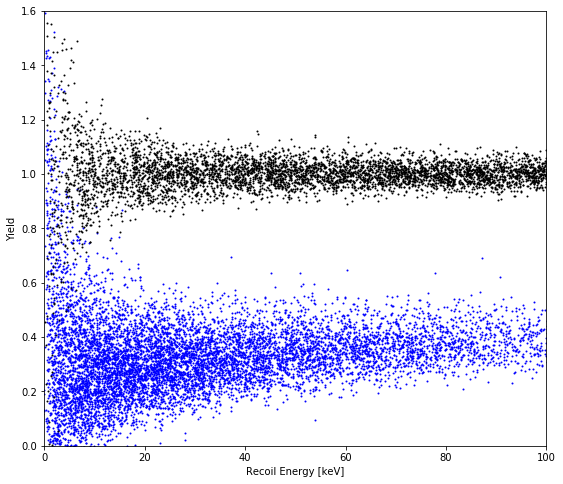

In [10]:
#plot 


fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,100,0.1)

ax1.plot(ER,Yield,'o',color='b',linewidth=2,markersize=1)
ax1.plot(ERer,Yield_er,'o',color='k',linewidth=2,markersize=1)
'''
ax1.plot(X,ynr_muv(X),color = 'orange',label='NR mu') #using old data 
#ax1.plot(xn,yn,'r--') #new fit to data (mean)

ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\sigma$')
ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

ax1.plot(X,yer_muv(X),color='purple',linestyle='--',label='ER mu')
ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='purple',linestyle='-',label='ER 3$\sigma$')
ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='purple',linestyle='-',label=None)
'''
ax1.set_xlabel('Recoil Energy [keV]')
ax1.set_ylabel('Yield')
ax1.set_ylim(0,1.6)
ax1.set_xlim(0,100)


plt.show()


In [11]:

data = np.vstack((ER,Yield,sigQ1,sigP1,U1,U2,N_eh)).T
print(data.shape)

x = data[data[:,1]>=0, :]

data1 = x[x[:,1]<=1.6,:]
data2 = data1[data1[:,0]>=0,:]


#data = np.vstack((Er,Y)).T
#print(data)
#np.savetxt("test_data.txt",data)

data1 = data2[np.argsort(data2[:, 0])]



(10000, 7)


In [12]:
#a,b,c,d,e,f,g = np.array_split(data1,7)
data = np.array_split(data1,20)



In [13]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [14]:
#Finds the width in a yield dist for a particular energy bin to be used later in yield variance calculation (fano)
def find_sigma(data):
    mu,sigma = norm.fit(data[:,1])
    
   # gaus(data[:,1],2,0.03,0.05)
    
    n,bins = np.histogram(data[:,1],60)
    
    a = max(data[:,1])
    b = np.average(data[:,1])
    c = sigma
    
    popt,pcov = curve_fit(gaus,bins[:-1],n,p0=[a,b,c])
    
    #y = mlab.normpdf(bins, mu, sigma)
 
    plt.figure()
    plt.hist(data[:,1],bins =60)
    plt.plot(bins,gaus(bins,*popt), 'r--', linewidth = 2)
    plt.xlabel("Yield")
    plt.show()
    
    return  pcov, popt

In [15]:
#finds average fano in particular energy bin
def gaus1(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_fano(data):
    
    mu,sigma = norm.fit(data)
    
    #gaus1(data,2,0.03,0.05)
    
    n,bins = np.histogram(data,60)
    
        
    a = max(data)
    b = mu
    c = sigma
    
    
    popt1,pcov1 = curve_fit(gaus1,bins[:-1],n,p0=[a,b,c])
    
    #y = mlab.normpdf(bins, mu, sigma)
 
    plt.figure()
    plt.hist(data,bins =60)
    plt.plot(bins,gaus(bins,*popt1), 'r--', linewidth = 2)
    plt.xlabel("Extracted Fano")
    plt.show()
    
    return  popt1, pcov1, mu

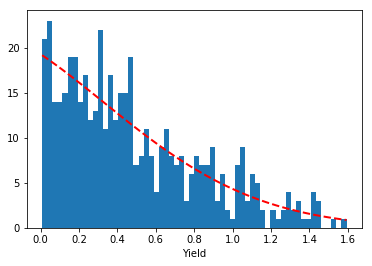

[[ 5.76254866e+01 -3.57447355e+00  1.41130574e+00]
 [-3.57447355e+00  2.29847083e-01 -9.35289209e-02]
 [ 1.41130574e+00 -9.35289209e-02  3.94635066e-02]] [23.08318352 -0.48705941  0.81202594]


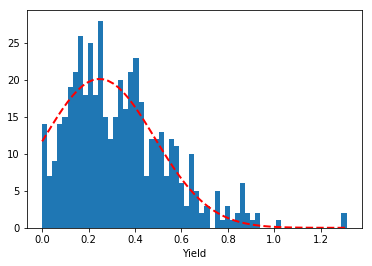

[[ 8.72429412e-01  2.44319023e-03 -9.55981238e-03]
 [ 2.44319023e-03  2.55550024e-04 -1.30610313e-04]
 [-9.55981238e-03 -1.30610313e-04  3.11487183e-04]] [20.12480921  0.24709183  0.23698513]


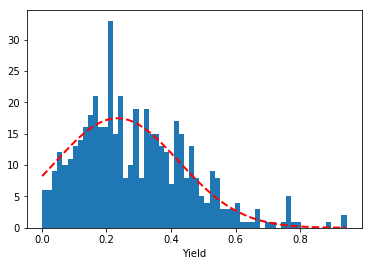

[[ 9.52191297e-01  1.82629520e-03 -9.04473699e-03]
 [ 1.82629520e-03  1.93104922e-04 -7.33933859e-05]
 [-9.04473699e-03 -7.33933859e-05  2.41512466e-04]] [17.46238614  0.23381809  0.19005422]


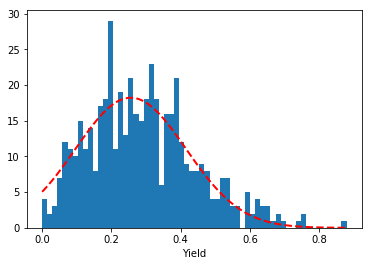

[[ 8.77326141e-01  5.67621155e-04 -5.87855121e-03]
 [ 5.67621155e-04  9.39253723e-05 -1.43363543e-05]
 [-5.87855121e-03 -1.43363543e-05  1.10242846e-04]] [18.22288463  0.25585991  0.15947621]


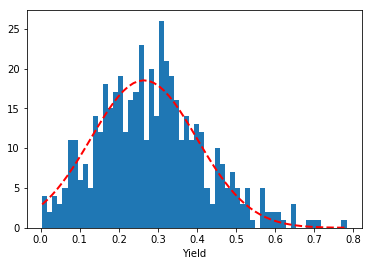

[[ 6.54463845e-01  1.42457054e-04 -3.41159779e-03]
 [ 1.42457054e-04  4.71042071e-05 -2.70314797e-06]
 [-3.41159779e-03 -2.70314797e-06  5.12135864e-05]] [18.51450755  0.26402788  0.13566682]


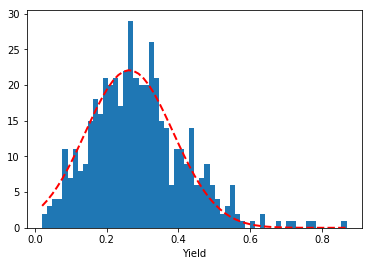

[[ 6.08176171e-01  7.82813902e-05 -2.36776932e-03]
 [ 7.82813902e-05  2.49456871e-05 -1.10185496e-06]
 [-2.36776932e-03 -1.10185496e-06  2.67202605e-05]] [22.06870883  0.26290368  0.12227879]


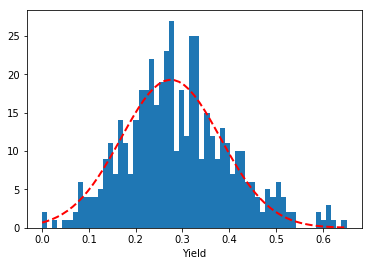

[[ 8.72283659e-01  1.08391601e-05 -3.21720434e-03]
 [ 1.08391601e-05  3.50916063e-05 -1.37563327e-07]
 [-3.21720434e-03 -1.37563327e-07  3.54140421e-05]] [19.30096369  0.27496582  0.10607561]


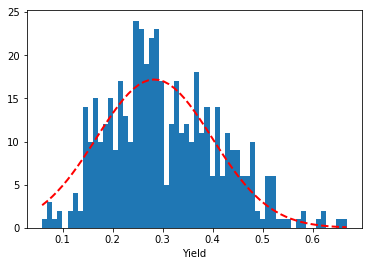

[[ 1.02121610e+00  1.93250325e-04 -4.87489694e-03]
 [ 1.93250325e-04  6.18941309e-05 -3.35368463e-06]
 [-4.87489694e-03 -3.35368463e-06  6.70957174e-05]] [17.18615358  0.2831546   0.11561928]


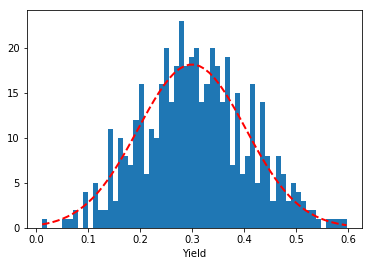

[[ 6.92000940e-01 -9.24929281e-08 -2.64105381e-03]
 [-9.24929281e-08  2.98623005e-05  1.21484176e-09]
 [-2.64105381e-03  1.21484176e-09  3.01005597e-05]] [18.14071267  0.29951335  0.10326885]


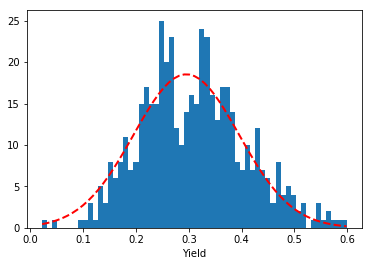

[[ 7.35791209e-01  3.03565284e-06 -2.65444575e-03]
 [ 3.03565284e-06  2.84223650e-05 -3.75380165e-08]
 [-2.65444575e-03 -3.75380165e-08  2.86160031e-05]] [18.53097289  0.29535718  0.09979768]


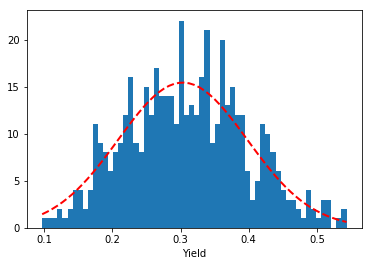

[[ 5.40976985e-01  2.84158631e-05 -2.31109199e-03]
 [ 2.84158631e-05  2.70749954e-05 -4.36143943e-07]
 [-2.31109199e-03 -4.36143943e-07  2.87140135e-05]] [15.4261029   0.30326934  0.09468228]


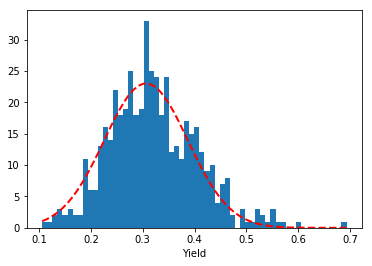

[[8.83327791e-01 1.07177115e-05 2.08270406e-03]
 [1.07177115e-05 1.44324363e-05 8.75806129e-08]
 [2.08270406e-03 8.75806129e-08 1.46239852e-05]] [23.0103341   0.30639152 -0.0806081 ]


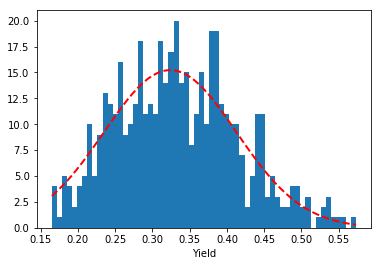

[[ 5.32725890e-01  1.37562211e-04 -2.28287384e-03]
 [ 1.37562211e-04  2.45442926e-05 -2.17312931e-06]
 [-2.28287384e-03 -2.17312931e-06  2.77163123e-05]] [15.23540309  0.32388907  0.08887707]


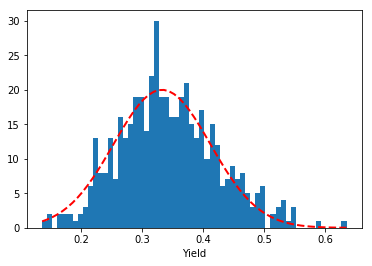

[[5.96292574e-01 8.87451197e-06 1.59388558e-03]
 [8.87451197e-06 1.25022653e-05 8.23572629e-08]
 [1.59388558e-03 8.23572629e-08 1.26809956e-05]] [19.98953906  0.33238725 -0.07932969]


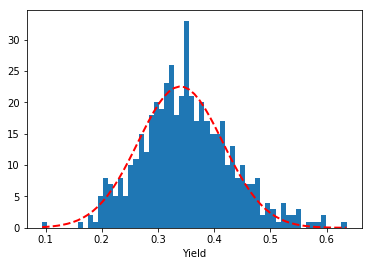

[[ 5.63370743e-01  1.13880888e-07 -1.25757450e-03]
 [ 1.13880888e-07  8.41727229e-06 -8.34638354e-10]
 [-1.25757450e-03 -8.34638354e-10  8.41996734e-06]] [22.51410818  0.3398455   0.07536695]


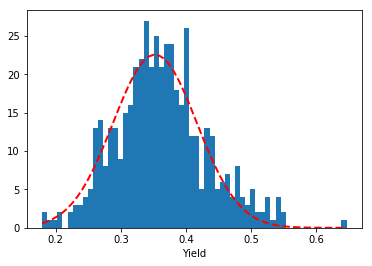

[[ 7.70770637e-01  2.93282010e-06 -1.46711734e-03]
 [ 2.93282010e-06  8.30514003e-06 -1.90215481e-08]
 [-1.46711734e-03 -1.90215481e-08  8.35119546e-06]] [22.57932806  0.35238768  0.06421475]


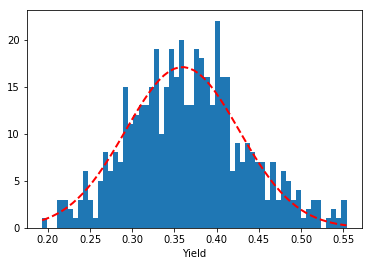

[[ 4.54935336e-01  5.50282832e-06 -1.20986266e-03]
 [ 5.50282832e-06  9.37879683e-06 -5.11895787e-08]
 [-1.20986266e-03 -5.11895787e-08  9.55356114e-06]] [17.07454051  0.35949884  0.06721433]


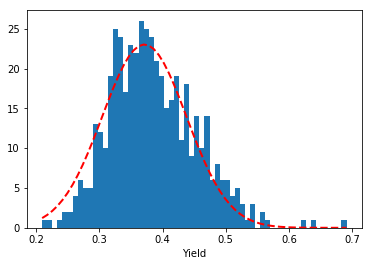

[[6.65492180e-01 8.66628733e-06 1.30110396e-03]
 [8.66628733e-06 7.43654260e-06 5.90255654e-08]
 [1.30110396e-03 5.90255654e-08 7.56155070e-06]] [23.01630034  0.37111128 -0.06668538]


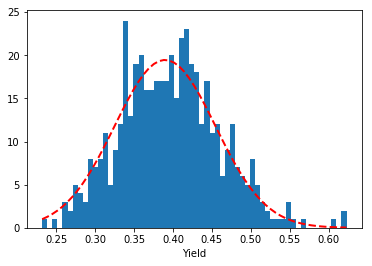

[[ 5.21866160e-01  7.69341666e-06 -1.17131010e-03]
 [ 7.69341666e-06  7.68649028e-06 -6.01626048e-08]
 [-1.17131010e-03 -6.01626048e-08  7.81504542e-06]] [19.45453078  0.38988289  0.06471176]


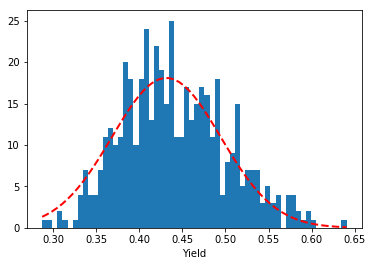

[[ 8.30379215e-01  2.37175295e-05 -1.96791727e-03]
 [ 2.37175295e-05  1.33789500e-05 -1.98504276e-07]
 [-1.96791727e-03 -1.98504276e-07  1.37743238e-05]] [18.09309287  0.43147663  0.06295298]
[0.8120259403682242, 0.23698512597344662, 0.19005421656568455, 0.15947621264619674, 0.13566682422779153, 0.12227879493435923, 0.1060756124691443, 0.11561927852745964, 0.10326885094284956, 0.09979768044194846, 0.09468228231126985, -0.08060810381424018, 0.08887707101297866, -0.07932968758277262, 0.07536695290488044, 0.0642147451652383, 0.0672143271802935, -0.0666853831074427, 0.06471176324687862, 0.062952977634946]


In [16]:

sig = []
for this_data in data:
    x,y = find_sigma(this_data)
    print(x,y)
    sig.append(y[2])
    
print(sig)

In [17]:
#Fano = (b[:,4]**2*b[:,2] +b[:,5]**2*b[:,3] -sigma)**2/(b[:,6]*(b[:,4]**2*eps + V/1000*b[:,5]**2))

def calc_fano(data,sig):
    mean = []
    error = []
    for x, sigy in zip(data, sig):
        #x = data[i]
        U1 = x[:,4]
        U2 = x[:,5]
        sigQ = x[:,2]
        sigP = x[:,3]
        #sigy =sig[i]
        N = x[:,6]
        
        Fano = (-U1**2*sigQ**2-U2**2*sigP**2 + sigy**2)/(U1**2*eps**2 +U2**2*(V/1000)**2)
        Fano = Fano/N
        print(min(x[:,0]),max(x[:,0]))
        
        x,y,z = find_fano(Fano)
        
        mean.append(x[1])
        error.append(y[1,1])
        
        print("mean :",x[1],",","uncertainty in mean : ",y[1,1])
        print(y)

       
    return mean, error
        
        



0.04821437788739881 2.9666075573100574


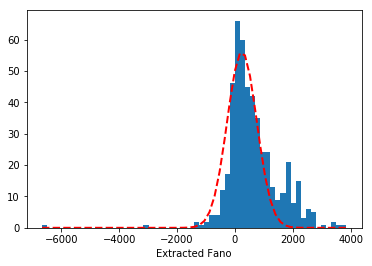

mean : 242.3183364636575 , uncertainty in mean :  912.6035231386088
[[ 8.28481096e+00  1.30706891e-07 -5.02020836e+01]
 [ 1.30706891e-07  9.12603523e+02  2.31529071e-06]
 [-5.02020836e+01  2.31529071e-06  9.12603521e+02]]
2.9686085079550333 5.627445437711981


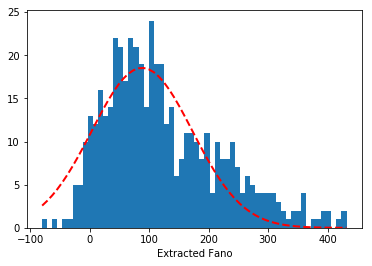

mean : 88.14993611292091 , uncertainty in mean :  26.180350414493024
[[ 0.94299827  0.10183973 -3.0228221 ]
 [ 0.10183973 26.18035041 -1.18106825]
 [-3.0228221  -1.18106825 28.07349215]]
5.629721217115465 7.977855376349523


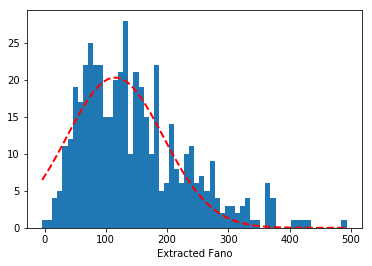

mean : 115.16183488210241 , uncertainty in mean :  30.167938221919552
[[ 1.40541454  0.49739631 -4.27280104]
 [ 0.49739631 30.16793822 -5.78036883]
 [-4.27280104 -5.78036883 36.15413156]]
7.990060115983713 10.44752997322646


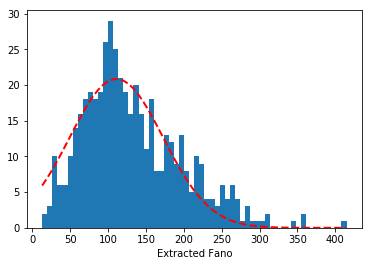

mean : 111.04099844229528 , uncertainty in mean :  10.608248753419813
[[ 0.86496732  0.19271102 -1.96399588]
 [ 0.19271102 10.60824875 -1.65054309]
 [-1.96399588 -1.65054309 12.47382052]]
10.449047916749162 12.842904998741442


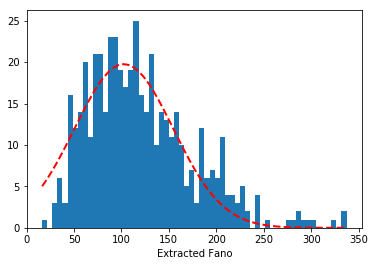

mean : 102.57412081805239 , uncertainty in mean :  9.347913400401898
[[ 0.9770291   0.16302172 -1.93799223]
 [ 0.16302172  9.3479134  -1.20879307]
 [-1.93799223 -1.20879307 10.8098215 ]]
12.84442395375677 15.708925571529104


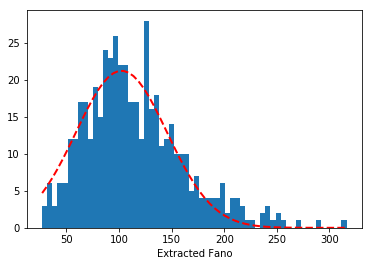

mean : 102.34310424665732 , uncertainty in mean :  3.971039851899356
[[ 0.69920192  0.07137977 -1.05294165]
 [ 0.07137977  3.97103985 -0.39774051]
 [-1.05294165 -0.39774051  4.49340976]]
15.711804091762131 18.57413764139836


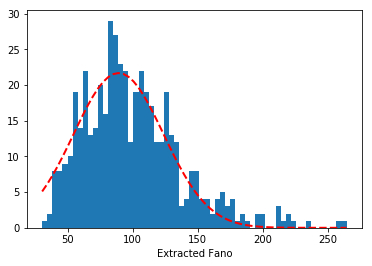

mean : 89.19281484899378 , uncertainty in mean :  3.203730065609416
[[ 0.92328491  0.08092706 -1.09320533]
 [ 0.08092706  3.20373007 -0.35589116]
 [-1.09320533 -0.35589116  3.65648742]]
18.58221414799798 21.964756714110887


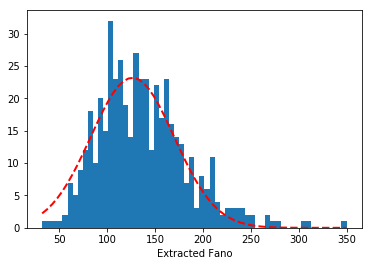

mean : 126.33741767455282 , uncertainty in mean :  5.5557496814362075
[[ 1.1848393   0.02741891 -1.52768997]
 [ 0.02741891  5.55574968 -0.12586752]
 [-1.52768997 -0.12586752  5.78524682]]
21.965636869594846 25.12964018481049


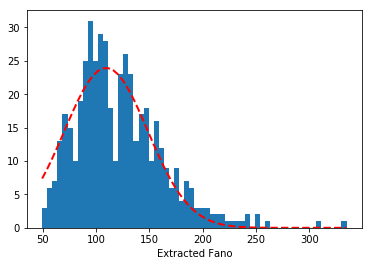

mean : 109.43150546982932 , uncertainty in mean :  4.511008852027168
[[ 1.19381832  0.16529519 -1.51603223]
 [ 0.16529519  4.51100885 -0.79760131]
 [-1.51603223 -0.79760131  5.367238  ]]
25.137447175812657 28.85126510674489


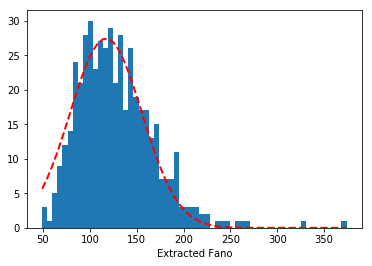

mean : 117.25721030223222 , uncertainty in mean :  2.1397887208746567
[[ 0.80968066  0.04826526 -0.8241395 ]
 [ 0.04826526  2.13978872 -0.18065467]
 [-0.8241395  -0.18065467  2.38923917]]
28.855908463794243 32.795118164265354


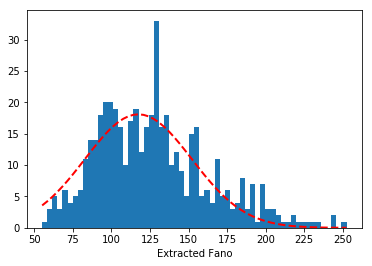

mean : 117.4929632972866 , uncertainty in mean :  5.813257034156566
[[ 1.17372294  0.09543221 -1.63500887]
 [ 0.09543221  5.81325703 -0.48919136]
 [-1.63500887 -0.48919136  6.48843303]]
32.79610084469738 37.8688745305128


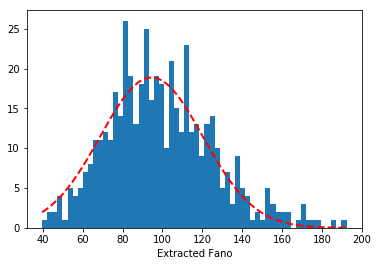

mean : 94.50847786764132 , uncertainty in mean :  1.7416754678755404
[[ 0.70148096  0.01403533 -0.66129011]
 [ 0.01403533  1.74167547 -0.04730877]
 [-0.66129011 -0.04730877  1.82531595]]
37.87767700966646 43.34721072171715


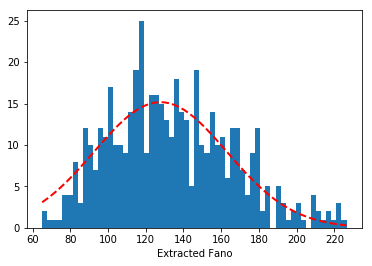

mean : 127.80826979489895 , uncertainty in mean :  5.384010889240338
[[ 0.74200439  0.07672823 -1.26254905]
 [ 0.07672823  5.38401089 -0.48142917]
 [-1.26254905 -0.48142917  6.08460546]]
43.35042142833695 49.75359305080721


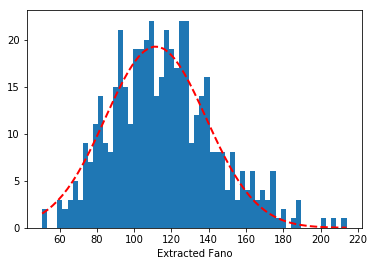

mean : 111.5582849676278 , uncertainty in mean :  1.5686570010463965
[[ 0.59970601  0.00767655 -0.5735537 ]
 [ 0.00767655  1.568657   -0.02596847]
 [-0.5735537  -0.02596847  1.61844104]]
49.75791769789461 57.050127285807946


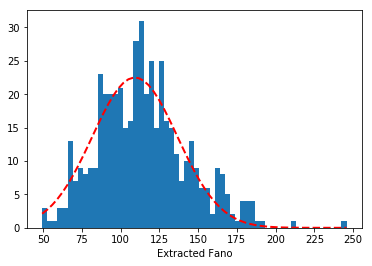

mean : 109.13101018235392 , uncertainty in mean :  2.15158361724046
[[ 1.08198842  0.01575751 -0.90770718]
 [ 0.01575751  2.15158362 -0.04702941]
 [-0.90770718 -0.04702941  2.23783478]]
57.053843122480544 65.78515734540724


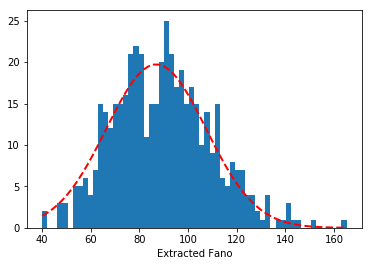

mean : 86.91517662530015 , uncertainty in mean :  0.7799299416590948
[[ 0.54337322  0.00454075 -0.38401733]
 [ 0.00454075  0.77992994 -0.01131911]
 [-0.38401733 -0.01131911  0.80205489]]
65.82779396222567 76.24497056811992


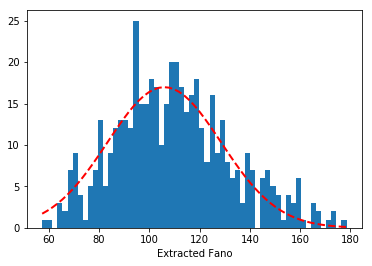

mean : 105.94625411578232 , uncertainty in mean :  1.576416089549556
[[ 0.66599955  0.01239203 -0.61274132]
 [ 0.01239203  1.57641609 -0.04075412]
 [-0.61274132 -0.04075412  1.65101904]]
76.30233983926406 91.64948266135583


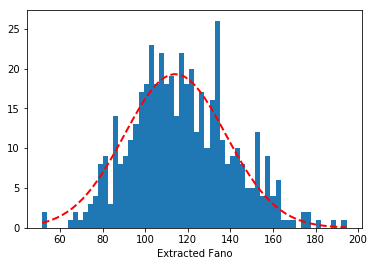

mean : 114.08182322862788 , uncertainty in mean :  1.5806217840433434
[[ 0.78137052  0.00181125 -0.64570158]
 [ 0.00181125  1.58062178 -0.00513948]
 [-0.64570158 -0.00513948  1.59343332]]
91.675858770165 121.69869083472831


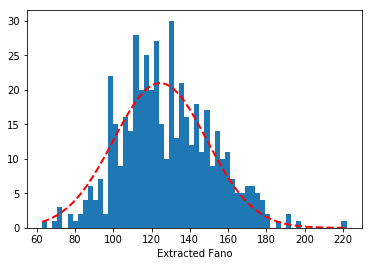

mean : 124.51639689713014 , uncertainty in mean :  2.4575905452465587
[[ 1.36496954  0.00469136 -1.06690788]
 [ 0.00469136  2.45759055 -0.01267176]
 [-1.06690788 -0.01267176  2.48583779]]
121.7297412117067 408.12184169794074


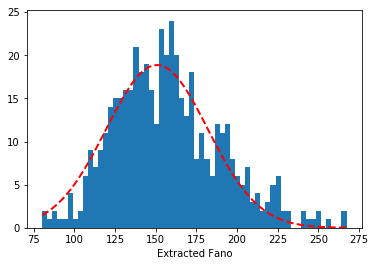

mean : 150.82415742809258 , uncertainty in mean :  2.061108541782722
[[ 0.56718637  0.00841599 -0.63916527]
 [ 0.00841599  2.06110854 -0.03353422]
 [-0.63916527 -0.03353422  2.12559925]]


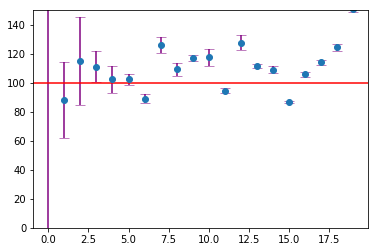

In [18]:
means,errors = calc_fano(data,sig)


x = np.arange(0,20)

plt.figure()
plt.errorbar(x,means,yerr=errors,fmt ='o',label = 'error', ecolor = 'purple', Linestyle = 'None', capsize=5, capthick=0.5)
plt.axhline(y=F, color='r', linestyle='-')
plt.ylim(0,150)
plt.show()